# plot

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import greatpy as gp 
import matplotlib.pyplot as plt 

import seaborn as sns 
import pandas as pd 

In [23]:
test = "../data/tests/test_data/input/01_random.bed"
regdom = "../data/human/hg38/regulatory_domain.bed"

## Count plot

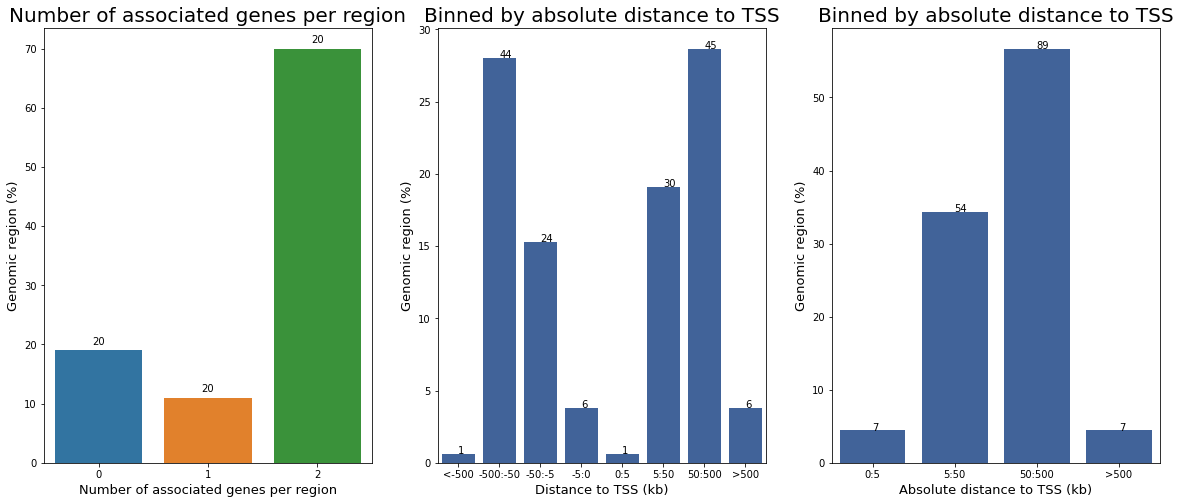

In [24]:
fig,ax = plt.subplots(1,3,figsize=(20,8))
gp.pl.graph_nb_asso_per_peaks(test,regdom,ax[0])
gp.pl.graph_dist_tss(test,regdom,ax[1])
gp.pl.graph_absolute_dist_tss(test,regdom,ax[2])
plt.show()

## Dotplot

In [5]:
enrichment = gp.tl.GREAT.enrichment(
    test,
    regdom,
    "../data/human/hg38/chr_size.bed", 
    "../data/human/ontologies.csv"
)

In [7]:
enrichment

,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment,intersection_size,recall
GO:0045887,positive regulation of synaptic growth at neur...,5.20389e-13,2.18004e+05,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0044721,"protein import into peroxisome matrix, substra...",4.84198e-10,3.94065e+04,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0036250,peroxisome transport along microtubule,4.84198e-10,3.94065e+04,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0016561,"protein import into peroxisome matrix, translo...",6.31855e-10,3.68645e+04,6.16839e-03,1.61871e+02,4,2.00000e+00
GO:0030576,Cajal body organization,1.49190e-09,2.97236e+04,1.83932e-02,5.39569e+01,4,6.66667e-01
...,...,...,...,...,...,...,...
GO:0006355,"regulation of transcription, DNA-templated",9.93956e-01,2.08617e+01,8.40449e-01,5.54352e-01,1,1.71233e-03
GO:0006915,apoptotic process,9.95014e-01,2.01230e+01,5.39651e-01,1.11443e+00,1,1.72117e-03
GO:0042803,protein homodimerization activity,9.98551e-01,2.44788e+01,9.54394e-01,3.33067e-01,2,2.05761e-03
GO:0005737,cytoplasm,9.98903e-01,6.55886e+01,9.92060e-01,5.70469e-01,24,4.22907e-03


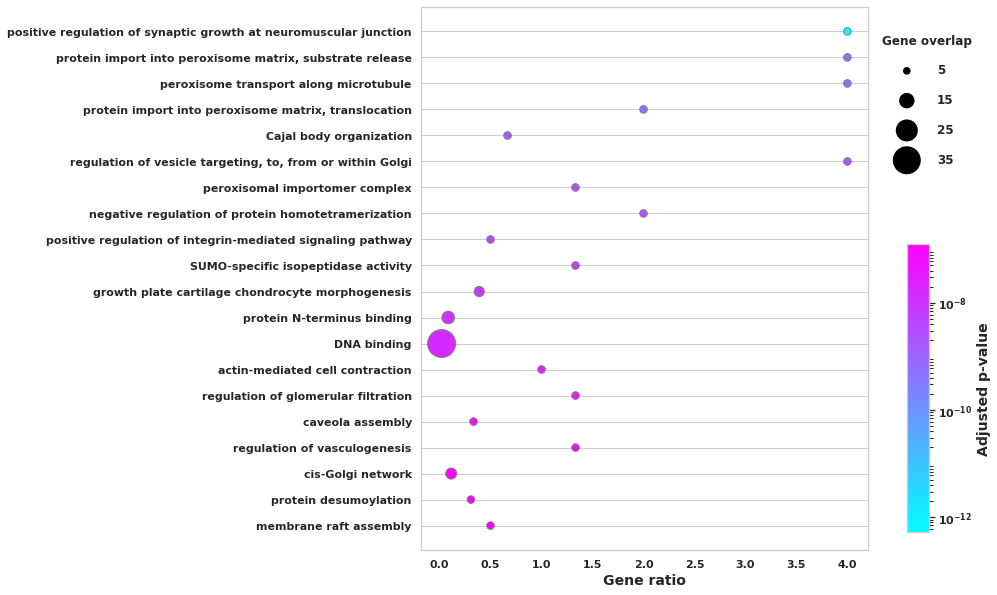

In [10]:
plot = enrichment.rename(columns={"binom_p_value" : "p_value", "go_term":"name"})
plt.figure(figsize=(10,10))
gp.pl.plot_enrich(plot)